In [1]:
import requests
import pandas as pd

# Pull launch data
launch_url = "https://api.spacexdata.com/v4/launches"
launch_data = requests.get(launch_url).json()

# Pull payloads and cores
payload_data = requests.get("https://api.spacexdata.com/v4/payloads").json()
core_data = requests.get("https://api.spacexdata.com/v4/cores").json()

# Create lookup dictionaries
payload_dict = {item["id"]: item for item in payload_data}
core_dict = {item["id"]: item for item in core_data}


In [2]:
data_rows = []

for launch in launch_data:
    # Do NOT filter out unsuccessful launches now
    if not launch["payloads"] or not launch["cores"]:
        continue

    payload_id = launch["payloads"][0]
    core_info = launch["cores"][0]
    core_id = core_info.get("core")

    payload = payload_dict.get(payload_id)
    core = core_dict.get(core_id) if core_id else None

    if not payload or not core:
        continue

    payload_mass = payload.get("mass_kg")
    reused = 1 if core.get("reused") else 0
    success = 1 if launch["success"] else 0  # this now includes both 1s and 0s

    if payload_mass is None or success is None:
        continue

    data_rows.append({
        "payload_mass_kg": payload_mass,
        "reused": reused,
        "success": success
    })

# Create DataFrame
spacex_df = pd.DataFrame(data_rows)
print("Dataset shape:", spacex_df.shape)
print(spacex_df['success'].value_counts(normalize=True))
spacex_df.head()


Dataset shape: (163, 3)
success
1    0.969325
0    0.030675
Name: proportion, dtype: float64


,payload_mass_kg,reused,success
0,20.0,0,0
1,165.0,0,1
2,200.0,0,1
3,525.0,0,1
4,400.0,0,1


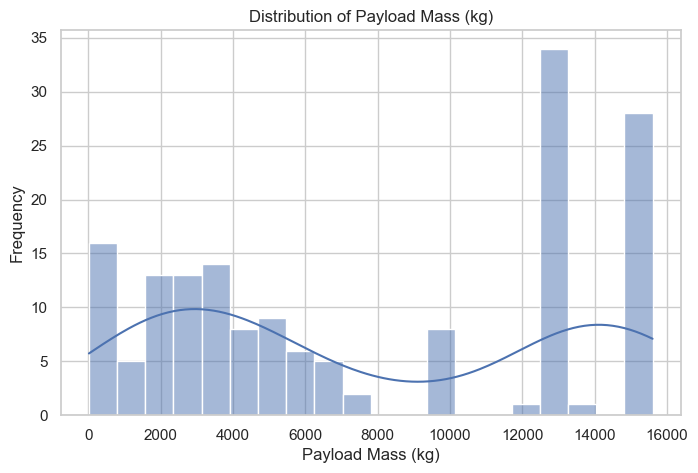

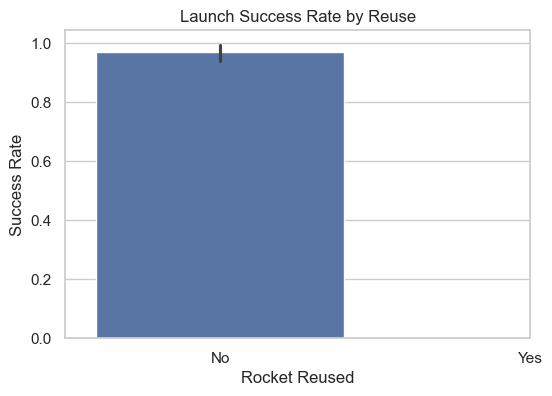

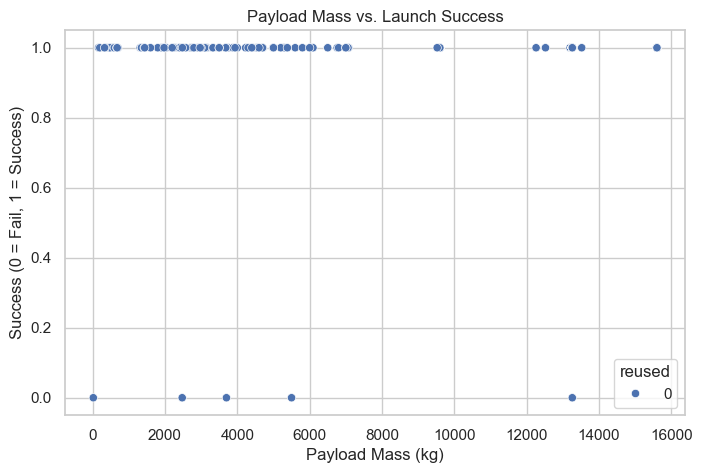

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Histogram – Payload Mass Distribution
plt.figure(figsize=(8, 5))
sns.histplot(spacex_df['payload_mass_kg'], bins=20, kde=True)
plt.title("Distribution of Payload Mass (kg)")
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Frequency")
plt.show()

# 2. Bar Plot – Success Rate by Reuse
plt.figure(figsize=(6, 4))
sns.barplot(x="reused", y="success", data=spacex_df)
plt.title("Launch Success Rate by Reuse")
plt.xlabel("Rocket Reused")
plt.ylabel("Success Rate")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# 3. Scatter – Payload Mass vs. Success
plt.figure(figsize=(8, 5))
sns.scatterplot(x="payload_mass_kg", y="success", hue="reused", data=spacex_df)
plt.title("Payload Mass vs. Launch Success")
plt.xlabel("Payload Mass (kg)")
plt.ylabel("Success (0 = Fail, 1 = Success)")
plt.show()


In [4]:
# Check for duplicates
duplicates = spacex_df.duplicated().sum()
print("Duplicate rows:", duplicates)

# Remove duplicates
spacex_df = spacex_df.drop_duplicates()
print("Shape after dropping duplicates:", spacex_df.shape)

# Check for missing values
print("\nMissing values per column:")
print(spacex_df.isnull().sum())

# Impute if needed (not expected here, but safe to include)
spacex_df['payload_mass_kg'] = spacex_df['payload_mass_kg'].fillna(spacex_df['payload_mass_kg'].median())
spacex_df['reused'] = spacex_df['reused'].fillna(spacex_df['reused'].mode()[0])
spacex_df['success'] = spacex_df['success'].fillna(spacex_df['success'].mode()[0])

print("\nMissing values after imputation:")
print(spacex_df.isnull().sum())


Duplicate rows: 69
Shape after dropping duplicates: (94, 3)

Missing values per column:
payload_mass_kg    0
reused             0
success            0
dtype: int64

Missing values after imputation:
payload_mass_kg    0
reused             0
success            0
dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define features and target
X = spacex_df[['payload_mass_kg', 'reused']]
y = spacex_df['success']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Model Coefficients: [-1.04845823e-05  0.00000000e+00]
Intercept: 0.989155163819348
Mean Squared Error: 0.05548826823873816
R² Score: -0.11284804634358214


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 1. Define features and target again
X = spacex_df[['payload_mass_kg', 'reused']]
y = spacex_df['success']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Train a logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# 4. Predict on test set
y_pred = clf.predict(X_test)

# 5. Evaluate performance
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# 6. Print results
print("Logistic Regression Evaluation:")
print("Accuracy:", acc)
print("F1 Score:", f1)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:\n", report)


Logistic Regression Evaluation:
Accuracy: 0.9473684210526315
F1 Score: 0.972972972972973

Confusion Matrix:
[[ 0  1]
 [ 0 18]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.95      1.00      0.97        18

    accuracy                           0.95        19
   macro avg       0.47      0.50      0.49        19
weighted avg       0.90      0.95      0.92        19



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  